In [1]:
import h5py
import numpy as np
from math import *
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector, Slider
from scipy.ndimage import median_filter, rotate, gaussian_filter
#import torch
from utils.fitting_methods import fit_gaussian_linear_background
import os
import glob
%matplotlib qt

C:\Users\Pratik\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def denoise_median_arrayed(data, size):
    # Apply median filter with a specified size (window size)
    filtered_data = np.apply_along_axis(lambda x: median_filter(x, size=2), axis=1, arr=data)
    filtered_data = median_filter(filtered_data, size=size)
    return filtered_data

def gaussian_2d(X, Y, mean, cov):
    pos = np.dstack((X, Y))
    diff = pos - mean
    inv_cov = np.linalg.inv(cov)
    exponent = np.einsum('...i,ij,...j->...', diff, inv_cov, diff)
    return np.exp(-0.5 * exponent) / (2 * np.pi * np.sqrt(np.linalg.det(cov)))

def smooth_saturated_values(image, sigma=3, threshold=None):
    """
    Smooths out saturated values using Gaussian filtering.

    Args:
        image (ndarray): 2D intensity array (image).
        sigma (float): Standard deviation for Gaussian kernel.
        threshold (float, optional): Saturation threshold. Defaults to max value in the image.

    Returns:
        ndarray: Smoothed image.
    """
    if threshold is None:
        threshold = np.max(image)  # Default to the max value in the image

    # Identify saturated pixels
    mask = image >= threshold-1
    # Apply Gaussian filtering to smooth the image
    smoothed_image = gaussian_filter(image, sigma=sigma)

    # Replace only the saturated pixels with the smoothed values
    image[mask] = smoothed_image[mask]

    return smoothed_image

In [3]:
##Opening the h5 and setting the relevant roi

def open_h5_file(file_path):
    with h5py.File(file_path, "r") as f:
        images = np.array(f['images'])
        res= f['images'].attrs['resolution']
    return images, res
dir = 'beamlines/awa/2025_02_20/QuadScan2/data'
number_of_h5_files = len(glob.glob(dir+ '/*.h5'))
print(number_of_h5_files)
images_Raw = []
for fname in os.listdir(dir):
        if fname.endswith(".h5"):
            file_path = os.path.join(dir, fname)
            images_single, res = open_h5_file(file_path)
            images_Raw.append(images_single)
            #print(np.shape(images_Raw))
            n_imgs = len(images_Raw[0])
    # res = 0.112
# images_Raw = z.reshape(1,1000,1000)
# n_imgs = 1
# res = 20/1000

images_Raw = images_Raw[5]
img = images_Raw[0]
plt.close('all')
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.1, bottom=0.25)
ax.set_title(f'Image 1/{n_imgs}')
imag = ax.imshow(img,  origin='lower')
# Create a slider axis and slider widget
ax_slider = plt.axes([0.1, 0.1, 0.65, 0.03], facecolor='lightgoldenrodyellow')
slider = Slider(ax_slider, 'Image', 1, n_imgs, valinit=1, valstep=1)

def update(val):
    index = int(slider.val) - 1
    imag.set_data(images_Raw[index])
    ax.set_title(f'Image {index + 1}/{n_imgs}')
    fig.canvas.draw_idle()

roi = []
def onselect_function(eclick, erelease):
    global roi
    roi = rect_selector.extents
    roi = np.array(roi, dtype=int)
    print("Extents: ", roi)

slider.on_changed(update)

rect_selector = RectangleSelector(ax, onselect_function, button=[1])

fig.canvas.manager.window.activateWindow() 

17


In [4]:
##Cropping all the images and verifying they look good

crop_verify = True

CroppedImages = images_Raw[:,roi[2]:roi[3], roi[0]:roi[1]]
if crop_verify:
    plt.close('all')
    fig, ax = plt.subplots(1,2)
    plt.subplots_adjust(left=0.1, bottom=0.25)
    img0 = ax[0].imshow(images_Raw[0],  origin='lower')
    img1 = ax[1].imshow(CroppedImages[0],  origin='lower')
    ax[0].set_title(f'Raw Image 1/{n_imgs}')
    ax[1].set_title(f'Cropped Image 1/{n_imgs}')
    # Create a slider axis and slider widget
    ax_slider = plt.axes([0.1, 0.1, 0.65, 0.03], facecolor='lightgoldenrodyellow')
    slider = Slider(ax_slider, 'Cropped Image', 1, n_imgs, valinit=1, valstep=1)
    def update(val):
        index = int(slider.val) - 1
        img0.set_data(images_Raw[index])
        img1.set_data(CroppedImages[index])
        ax[0].set_title(f'Raw Image {index + 1}/{n_imgs}')
        ax[1].set_title(f'Cropped Image {index + 1}/{n_imgs}')
        fig.canvas.draw_idle()
    slider.on_changed(update)
    fig.canvas.manager.window.activateWindow() 

In [5]:
##Filter all the images and verifying they look good
%matplotlib qt
filter_verify = True

window_size = 10
sigma_size=3

FilterImages = denoise_median_arrayed(CroppedImages, window_size)
FilterImages = smooth_saturated_values(FilterImages, sigma_size)

if filter_verify:
    plt.close('all')
    fig, ax = plt.subplots(1,2)
    plt.subplots_adjust(left=0, bottom=0.25)
    img0 = ax[0].imshow(CroppedImages[0],  origin='lower')
    img1 = ax[1].imshow(FilterImages[0],  origin='lower')
    ax[0].set_title(f'Cropped Image 1/{n_imgs}')
    ax[1].set_title(f'Filtered Image 1/{n_imgs}')
    
    # Create a slider axis and slider widget
    ax_slider = plt.axes([0.1, 0.1, 0.65, 0.03], facecolor='lightgoldenrodyellow')
    slider = Slider(ax_slider, 'Filtered Image', 1, n_imgs, valinit=1, valstep=1)
    def update(val):
        index = int(slider.val) - 1
        img0.set_data(CroppedImages[index])
        img1.set_data(FilterImages[index])
        ax[0].set_title(f'Cropped Image {index + 1}/{n_imgs}')
        ax[1].set_title(f'Filtered Image {index + 1}/{n_imgs}')
        fig.canvas.draw_idle()
    slider.on_changed(update)
    fig.canvas.manager.window.activateWindow() 


In [6]:
##Find good threshold
import time
plt.close('all')
test_img = FilterImages[0]
thresholds = np.linspace(0,np.mean(test_img)*2,20)
print(thresholds)
Cx, Cy, Sx, Sy, Rx, Ry = np.zeros((6, len(thresholds)))
i = 0
from IPython.display import display
def close_event():
    plt.close() #timer calls this function after 3 seconds and closes the window


def calculate_rms_vectorized(image, Cx, Cy):
    """
    Calculate the RMS size using a vectorized approach.

    Args:
        image (ndarray): The input 2D image.
        Cx (ndarray): The x-coordinate centers for each image.
        Cy (ndarray): The y-coordinate centers for each image.

    Returns:
        Rx (ndarray): The RMS size in the x-direction for each image.
        Ry (ndarray): The RMS size in the y-direction for each image.
    """
    # Initialize arrays for the RMS values
    Rx = 0
    Ry = 0

    #print(Cx,Cy)
    dx = np.arange(image.shape[1]) - Cx
    dy = np.arange(image.shape[0]) - Cy
    #print(dx)

    # Create 2D grids of differences
    dx_grid, dy_grid = np.meshgrid(dx, dy)

    # Calculate squared differences, weighted by the image intensity
    Xnom = np.sum(image *dx_grid**2)
    Ynom = np.sum(image *dy_grid**2)

    # Normalize by the sum of image intensities (denom)
    denom = np.sum(image)

    # Calculate RMS sizes in x and y directions
    Rx = np.sqrt(Xnom / denom)
    Ry = np.sqrt(Ynom / denom)

    return Rx, Ry

for bg in thresholds:
    temp_im = test_img-bg
    temp_im[temp_im<0]=0
    x_projection = np.sum(temp_im, axis=0)
    y_projection = np.sum(temp_im, axis=1)
    [_, Cx[i], Sx[i], _] = fit_gaussian_linear_background(x_projection, visualize=False)
    [_, Cy[i], Sy[i], _] = fit_gaussian_linear_background(y_projection, visualize=False)
    Xnom, Ynom, XYnom, denom = 0,0,0,0
    #Calculate RMS
    """
    for y in range(temp_im.shape[0]):
        for x in range(temp_im.shape[1]):
            Xnom = Xnom + temp_im[y,x]*(x-Cx[i])*(x-Cx[i])
            Ynom = Ynom + temp_im[y,x]*(y-Cy[i])*(y-Cy[i])
            denom = denom + temp_im[y,x]
    Rx[i] = Xnom/denom
    Ry[i] = Ynom/denom
    i = i+1
    """
    Rx[i], Ry[i] = calculate_rms_vectorized(temp_im, Cx[i], Cy[i])
    #plt.axvline(Cx[i]+Rx[i],linestyle='--')
    #plt.axhline(Cy[i]+Ry[i],linestyle='--')
    #plt.show()  # Display the plot without blocking
    #fig = plt.gcf()  # Grabs the current figure
    #plt.imshow(temp_im)
    #plt.scatter(Cx[i],Cy[i],color='red')
    #plt.axvline(Cx[i]+Sx[i],color='red')
    #plt.axvline(Cx[i]-Sx[i],color='red')
    #plt.axhline(Cy[i]-Sy[i],color='red')
    #plt.axhline(Cy[i]+Sy[i],color='red')
    #plt.axvline(Rx[i]+Cx[i])
    #plt.axvline(Cx[i]-Rx[i])
    #plt.axhline(Cy[i]-Ry[i])
    #plt.axhline(Cy[i]+Ry[i])
    #display(fig)
    #plt.clf()
    i = i+1
print('done')
plt.plot(thresholds, Sx,label='Sx')
plt.plot(thresholds, Sy,label='Sy')
plt.plot(thresholds, Rx,label='RMSX')
plt.plot(thresholds, Ry,label='RMSY')
#.plot(thresholds,np.gradient(Rx,thresholds), label='RMSX_prime')
plt.legend()

[   0.          371.31823113  742.63646225 1113.95469338 1485.2729245
 1856.59115563 2227.90938675 2599.22761788 2970.545849   3341.86408013
 3713.18231125 4084.50054238 4455.8187735  4827.13700463 5198.45523575
 5569.77346688 5941.091698   6312.40992913 6683.72816025 7055.04639138]
done


In [7]:
import matplotlib.patches as patches
plt.close('all')
%matplotlib qt
##Get rms values for x, y, and xy and sigma x,y, xy
bg = 3000
test_img = FilterImages[0]
temp_im = test_img-bg
temp_im[temp_im<0]=0
x_projection = np.sum(temp_im, axis=0)
y_projection = np.sum(temp_im, axis=1)
[_, Cx, Sx, _] = fit_gaussian_linear_background(x_projection, visualize=False)
[_, Cy, Sy, _] = fit_gaussian_linear_background(y_projection, visualize=False)

fig, ax = plt.subplots(1,2)
ax[0].imshow(temp_im, origin='lower')
scalex, scaley = temp_im.shape; scalex, scaley = scalex/5, scaley/5 
ax[0].plot(x_projection/max(x_projection)*scalex, 'w', linestyle='--')
ax[0].plot(y_projection/max(y_projection)*scaley,np.arange(len(y_projection)), 'w', linestyle='--')
ax[0].plot([Cx-Sx/2,Cx+Sx/2],[Cy,Cy], linestyle='-', color='r', markersize=10)
ax[0].plot([Cx,Cx],[Cy-Sy/2,Cy+Sy/2], linestyle='-', color='r', markersize=10)
envelope = patches.Ellipse((Cx,Cy), 4*Sx, 4*Sy, angle=0, edgecolor = 'black', facecolor='None')
ax[0].add_patch(envelope)
plt.show()

dim1,dim2=np.shape(temp_im)
img45_cropped=rotate(temp_im,-45,reshape=True,order=1)
x_projection45 = np.sum(img45_cropped, axis=0)
y_projection45 = np.sum(img45_cropped, axis=1)
[_, Cx45, Sx45, _] = fit_gaussian_linear_background(x_projection45, visualize=False)
[_, Cy45, Sy45, _] = fit_gaussian_linear_background(y_projection45, visualize=False)
Sxy=(Sx45**2-Sy45**2)/2
#ax[1].imshow(img45_cropped, origin='lower')
#scalex, scaley = img45_cropped.shape; scalex, scaley = scalex/5, scaley/5
#ax[1].plot(x_projection45/max(x_projection45)*scalex, 'w', linestyle='--')
#ax[1].plot(y_projection45/max(y_projection45)*scaley,np.arange(len(y_projection45)), 'w', linestyle='--')
#ax[1].plot([Cx45-Sx45/2,Cx45+Sx45/2],[Cy45,Cy45], linestyle='-', color='r', markersize=10)
#ax[1].plot([Cx45,Cx45],[Cy45-Sy45/2,Cy45+Sy45/2], linestyle='-', color='r', markersize=10)
#ax[1].set_visible(False)


print(f'Cx = {Cx} | Cy = {Cy} | Sxx = {Sx*res*Sx*res} mm^2 | Syy = {Sy*res*Sy*res} mm^2 | Sxy = {Sxy*res*res} mm^2')

Xnom, Ynom, denom = 0,0,0

#Caculate Centroid
for i in range(temp_im.shape[0]):
    for j in range(temp_im.shape[1]):
        Xnom = Xnom + temp_im[i,j]*(j)
        Ynom = Ynom + temp_im[i,j]*(i)
        denom = denom + temp_im[i,j]

Xcen = Xnom/denom
Ycen = Ynom/denom

Xnom, Ynom, XYnom, denom = 0,0,0,0
#Calculate RMS
for i in range(temp_im.shape[0]):
    for j in range(temp_im.shape[1]):
        Xnom = Xnom + temp_im[i,j]*(j-Xcen)*(j-Xcen)
        Ynom = Ynom + temp_im[i,j]*(i-Ycen)*(i-Ycen)
        XYnom = XYnom + temp_im[i,j]*(j-Xcen)*(i-Ycen)
        denom = denom + temp_im[i,j]

RMSx = Xnom/denom
RMSy = Ynom/denom
RMSxy = XYnom/denom
print(f'Xcen = {Xcen} | Ycen = {Ycen} | RMSx = {RMSx} | RMSy = {RMSy} | RMSxy = {RMSxy}')

# Parameters for the Gaussian distribution
mean = np.array([Cx, Cy])  # Centroid (mean) of the distribution
covariance = np.array([[Sx*Sx, -Sxy], [-Sxy, Sy*Sy]])  # Covariance matrix
RMSmean = np.array([Xcen, Ycen])  # Centroid (mean) of the distribution
RMScovariance = np.array([[RMSx, RMSxy], [RMSxy, RMSy]])  # Covariance matrix

# Create a grid of points
x = np.linspace(ax[0].get_xlim()[0], ax[0].get_xlim()[1], 1000)
y = np.linspace(ax[0].get_ylim()[0], ax[0].get_ylim()[1], 1000)
X, Y = np.meshgrid(x, y)

# Compute the Gaussian values
Z = gaussian_2d(X, Y, mean, covariance)
sigma1,sigma2,sigma3, sigma4,sigma6= gaussian_2d(Cx+Sx/2, Cy, mean, covariance),gaussian_2d(Cx+Sx, Cy, mean, covariance),gaussian_2d(Cx+3*Sx/2, Cy, mean, covariance), gaussian_2d(Cx+2*Sx, Cy, mean, covariance),gaussian_2d(Cx+3*Sx, Cy, mean, covariance)
sigmac = ax[0].contour(X,Y,Z, levels=sigma4 ,colors='black', linestyles='dashed')
#plt.clabel(sigmac, inline=True, fmt=f'$4\sigma$',color='black')
Z = gaussian_2d(X, Y, RMSmean, RMScovariance)
simgma4 = gaussian_2d(Xcen+2*sqrt(RMSx), Ycen, RMSmean, RMScovariance)
rmsc = ax[0].contour(X,Y,Z, levels=sigma4,colors='black', linestyles='dashed')
plt.clabel(rmsc, inline=True, fmt=f'4RMS')

matrixstr = f'Beam Matrix $\Sigma$ \n\n$\sigma_{{xx}} , \sigma_{{xy}}$ \n $\sigma_{{xy}} , \sigma_{{yy}}$ \n \nUnits Below \nare in [$mm^2$] \n\nFrom Gaussian Fit \n\n {Sx*Sx*res*res:.2f} , {-Sxy*res*res:.2f} \n {-Sxy*res*res:.2f} , {Sy*Sy*res*res:.2f}\n\nRMS Calcuation \n\n {RMSx*res*res:.2f} , {RMSxy*res*res:.2f} \n {RMSxy*res*res:.2f} , {RMSy*res*res:.2f}'

props = dict(boxstyle='round', facecolor='grey', alpha=0.15)  # bbox features
ax[0].text(1.03, 0.85, matrixstr, transform=ax[0].transAxes, fontsize=12, verticalalignment='top', bbox=props)
#fig.tight_layout()
plt.show()

<>:90: SyntaxWarning: invalid escape sequence '\S'
<>:90: SyntaxWarning: invalid escape sequence '\s'
<>:90: SyntaxWarning: invalid escape sequence '\s'
<>:90: SyntaxWarning: invalid escape sequence '\s'
<>:90: SyntaxWarning: invalid escape sequence '\S'
<>:90: SyntaxWarning: invalid escape sequence '\s'
<>:90: SyntaxWarning: invalid escape sequence '\s'
<>:90: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Pratik\AppData\Local\Temp\ipykernel_17492\86784263.py:90: SyntaxWarning: invalid escape sequence '\S'
  matrixstr = f'Beam Matrix $\Sigma$ \n\n$\sigma_{{xx}} , \sigma_{{xy}}$ \n $\sigma_{{xy}} , \sigma_{{yy}}$ \n \nUnits Below \nare in [$mm^2$] \n\nFrom Gaussian Fit \n\n {Sx*Sx*res*res:.2f} , {-Sxy*res*res:.2f} \n {-Sxy*res*res:.2f} , {Sy*Sy*res*res:.2f}\n\nRMS Calcuation \n\n {RMSx*res*res:.2f} , {RMSxy*res*res:.2f} \n {RMSxy*res*res:.2f} , {RMSy*res*res:.2f}'
C:\Users\Pratik\AppData\Local\Temp\ipykernel_17492\86784263.py:90: SyntaxWarning: invalid escape sequence '\s'
  matr

Cx = 420.20927600862285 | Cy = 101.39871149046084 | Sxx = 0.3708458333746053 mm^2 | Syy = 0.6594900520463598 mm^2 | Sxy = 7.032911421784948 mm^2


C:\Users\Pratik\AppData\Local\Temp\ipykernel_17492\86784263.py:50: RuntimeWarning: overflow encountered in scalar add
  denom = denom + temp_im[i,j]
C:\Users\Pratik\AppData\Local\Temp\ipykernel_17492\86784263.py:48: RuntimeWarning: overflow encountered in scalar multiply
  Xnom = Xnom + temp_im[i,j]*(j)
C:\Users\Pratik\AppData\Local\Temp\ipykernel_17492\86784263.py:48: RuntimeWarning: overflow encountered in scalar add
  Xnom = Xnom + temp_im[i,j]*(j)
C:\Users\Pratik\AppData\Local\Temp\ipykernel_17492\86784263.py:49: RuntimeWarning: overflow encountered in scalar add
  Ynom = Ynom + temp_im[i,j]*(i)
C:\Users\Pratik\AppData\Local\Temp\ipykernel_17492\86784263.py:49: RuntimeWarning: overflow encountered in scalar multiply
  Ynom = Ynom + temp_im[i,j]*(i)
C:\Users\Pratik\AppData\Local\Temp\ipykernel_17492\86784263.py:62: RuntimeWarning: overflow encountered in scalar add
  denom = denom + temp_im[i,j]


Xcen = 0.6063381910710155 | Ycen = 0.09171100316138484 | RMSx = 26050898120.80012 | RMSy = 43015880620.75608 | RMSxy = 24365155194.189884


C:\Users\Pratik\AppData\Local\Temp\ipykernel_17492\31408549.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.exp(-0.5 * exponent) / (2 * np.pi * np.sqrt(np.linalg.det(cov)))


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the Gaussian distribution
mean = (0, 0)  # Mean of the distribution
covariance = np.array([[1, -2],
                       [-2, 5]])  # Covariance matrix

# Generate a grid of points
x, y = np.meshgrid(np.linspace(-10, 10, 1000), np.linspace(-10, 10, 1000))

# Combine the x and y coordinates into a single array
pos = np.dstack((x, y))

# Define the 2D Gaussian function
def gaussian_2d(x, y, mean, cov):
    inv_cov = np.linalg.inv(cov)
    diff = np.dstack((x - mean[0], y - mean[1]))
    exponent = -0.5 * np.sum(np.dot(diff, inv_cov) * diff, axis=2)
    return np.exp(exponent) / (2 * np.pi * np.sqrt(np.linalg.det(cov)))

# Calculate the Gaussian values
z = gaussian_2d(x, y, mean, covariance)
# Plotting
plt.contourf(x, y, z, levels=50, cmap='viridis')
plt.colorbar()
plt.title('2D Gaussian Distribution')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


[0.41421356 2.41421356]


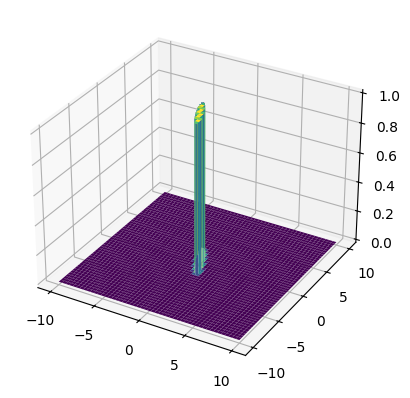

In [106]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Define the covariance matrix
cov_matrix = np.array([[1, -2], [-2, 5]])

# Compute the eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
radii = np.sqrt(eigenvalues)  # Radii of the ellipse
print(radii)
x = np.linspace(-10, 10, 1000)
y = np.linspace(-10, 10, 1000)

X, Y = np.meshgrid(x,y)

points = np.vstack([X.ravel(), Y.ravel()])

radii_squared = np.square(radii)
radii_squared = radii_squared[:, np.newaxis]
transformed_points = np.dot(np.linalg.inv(eigenvectors), points)
transformed_points_squared = np.square(transformed_points)
ellipse_condition = np.sum(transformed_points_squared/radii_squared, axis=0)

z =np.where(ellipse_condition < 1, 1, 0)

Z = z.reshape(X.shape)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#contour = plt.contour(X,Y,Z, levels = [0,1], cmap = 'viridis')
#cbar = plt.colorbar(contour)
#cbar.set_label('Z')
ax.plot_surface(X,Y,Z, cmap = 'viridis')
